In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [12]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [13]:
tweets_train.loc[tweets_train['keyword'].notnull() == False,'cleaned_text'] = tweets_train['text'] 
tweets_train.loc[tweets_train['keyword'].notnull() == True,'cleaned_text'] = tweets_train['keyword'] + ' ' + tweets_train['text']

In [14]:
tweets_test.loc[tweets_test['keyword'].notnull() == False,'cleaned_text'] = tweets_test['text'] 
tweets_test.loc[tweets_test['keyword'].notnull() == True,'cleaned_text'] = tweets_test['keyword'] + ' ' + tweets_test['text']

In [15]:
tweets_train.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#RockyFire Update => California Hwy. 20 closed...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster Heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,I'm on top of the hill and I can see a fire in...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,There's an emergency evacuation happening now ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,I'm afraid that the tornado is coming to our a...


In [16]:
#Eliminamos los emojis del texto
def remove_emoji(text):
    emoji_list = re.compile("["u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\u200d"
                               u"\u2640-\u2642"
                           "]+", flags=re.UNICODE)
    return emoji_list.sub(r'', text)

In [17]:
#Almacenamos el texto limpio en una nueva feature del dataframe
tweets_train['cleaned_text']=tweets_train['cleaned_text'].apply(lambda x: remove_emoji(x))
tweets_test['cleaned_text']=tweets_test['cleaned_text'].apply(lambda x: remove_emoji(x))

In [18]:
#Eliminamos los numeros y '_' del texto 
tweets_train['cleaned_text']=tweets_train['cleaned_text'].apply(lambda x: re.sub(r'[0-9_]','',x))
tweets_test['cleaned_text']=tweets_test['cleaned_text'].apply(lambda x: re.sub(r'[0-9_]','',x))

In [19]:
tweets_train.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,", people receive #wildfires evacuation orders ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#RockyFire Update => California Hwy. closed i...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster Heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,I'm on top of the hill and I can see a fire in...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,There's an emergency evacuation happening now ...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,I'm afraid that the tornado is coming to our a...


In [20]:
tweets_test.head(10)

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?,Hey! How are you?
8,27,NaN,NaN,What a nice hat?,What a nice hat?
9,29,NaN,NaN,Fuck off!,Fuck off!


In [21]:
x = tweets_train.cleaned_text
y = tweets_train.target

In [22]:
#Separamos al dataset tweets_train en un set de entrenamiento y uno de validacion, para text y para target
#El tamaño del set de validacion es del 20% del original
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
#Bag of Words 
#Vectorizamos los textos de cada tweet eliminando los stopwords
count_vect = CountVectorizer(stop_words = ('english'), lowercase = True)
tweets_train_counts = count_vect.fit_transform(x_train)
tweets_test_counts = count_vect.transform(x_test)
tweets_train_counts.shape
#print(count_vect.get_feature_names())

(6090, 17669)

In [24]:
#TFIDF
tfidf_transformer = TfidfTransformer()
tweets_train_tfidf = tfidf_transformer.fit_transform(tweets_train_counts)
tweets_test_tfidf = tfidf_transformer.transform(tweets_test_counts)
tweets_train_tfidf.shape

(6090, 17669)

In [25]:
#Naive Bayes
tweets_train_NB = MultinomialNB().fit(tweets_train_tfidf, y_train)

In [26]:
predicted = tweets_train_NB.predict(tweets_test_tfidf)
np.mean(predicted == y_test)

0.7852921864740644

In [29]:
#Realizamos gridsearch para buscar el mejor hiperparametro
parameters = {'alpha': ([0.001,0.1,0.3,0.5,0.6,1])}

gs_NB = GridSearchCV(tweets_train_NB, parameters, n_jobs=-1, cv=3)
gs_NB = gs_NB.fit(tweets_train_tfidf, y_train)

gs_NB_best = gs_NB.best_estimator_
gs_NB.best_score_
gs_NB.best_params_

{'alpha': 0.3}

In [30]:
best_NB = gs_NB_best.fit(tweets_train_tfidf, y_train)

In [31]:
predicted = best_NB.predict(tweets_test_tfidf)
np.mean(predicted == y_test)

0.7859487852921865

In [32]:
test_text = tweets_test.cleaned_text
test_text_counts = count_vect.transform(test_text)
test_text_tfidf = tfidf_transformer.transform(test_text_counts)
test_target_predicted = best_NB.predict(test_text_tfidf)

In [33]:
tweets_submission.target = test_target_predicted
tweets_submission.to_csv("submission.csv",index=False)

Text(0, 0.5, 'Cantidad de tweets')

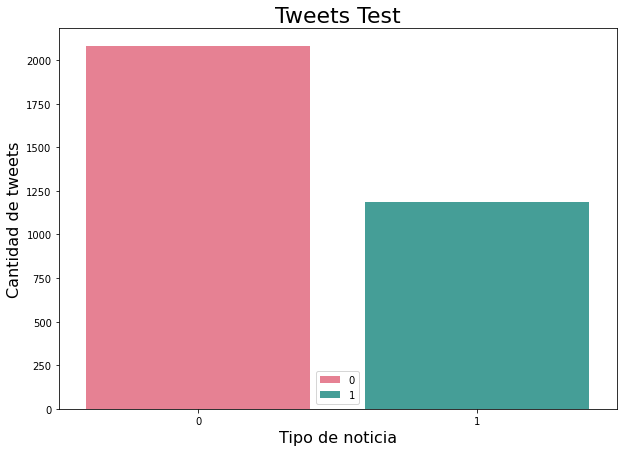

In [34]:
plt.figure(figsize=(10,7))
g = sns.barplot(x= tweets_submission.target.value_counts().index, y= tweets_submission.target.value_counts().values, orient='v', palette= 'husl', hue= tweets_submission.target.value_counts().index, dodge=False)
g.set_title("Tweets Test", fontsize=22)
g.set_xlabel("Tipo de noticia", fontsize=16)
g.set_ylabel("Cantidad de tweets", fontsize=16)